In [1]:
import os
import warnings
import time
import librosa
import librosa.display 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

warnings.filterwarnings('ignore')

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Importowanie bibliotek i łączenie się z Google Drive'em


In [3]:
df = pd.read_csv('/content/gdrive/MyDrive/Licencjat/UrbanSound8K.csv')
sound_names = ['klimatyzacja', 'klakson', 'bawiące się dzieci', 'szczekający pies', 'wiercenie',
               'silnik na biegu jałowym', 'strzały z broni palnej', 'młot pneumatyczny', 'syrena', 'muzyka uliczna']
sound_names_short = ['KLIM', 'KLAK', 'DZIE', 'PIES', 'WIER',
                     'SIL', 'STRZ', 'MŁOT', 'SYR', 'UL']
folder_names = ['folder1', 'folder2', 'folder3', 'folder4', 'folder5',
                'foldr6', 'folder7', 'folder8', 'folder9', 'folder10']

In [4]:
def get_fourier(data, sampling_rate):
    data_length = len(data)
    frequency = np.fft.rfftfreq(data_length, d=1/sampling_rate)
    Y = abs(np.fft.rfft(data)/data_length)
    return (Y, frequency)

In [5]:
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


Można zaobserwować jak wygląda struktura pliku .CSV z informacjami o dźwiękach. Każdy plik ma przypisany folder oraz kategorię. Kolumna "salience" oznacza (subiektywną) ocenę źródła dźwieku - 1 == pierwszy plan, 2 == tło.


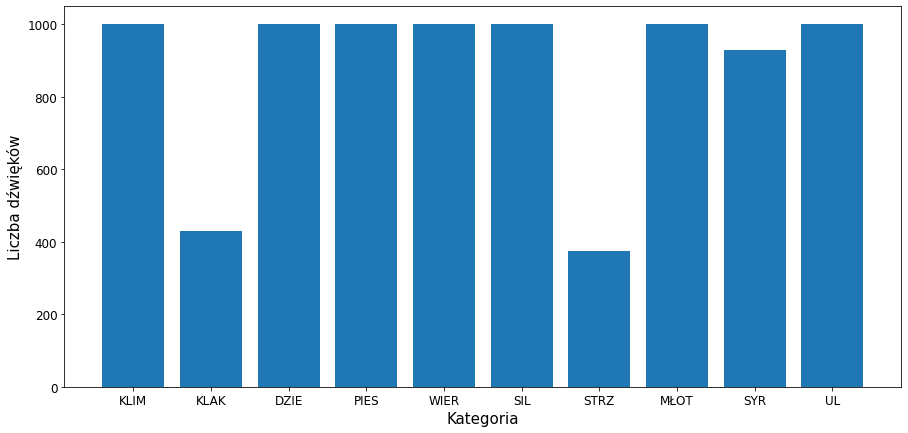

In [6]:
sound_list = list(df['classID'])
sound_counter = [sound_list.count(k) for k in range(0, len(sound_names))]

plt.figure(figsize=(15,7))
plt.bar(sound_names_short, sound_counter)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Kategoria', fontsize=15)
plt.ylabel('Liczba dźwięków', fontsize=15)
plt.savefig('rozklad.png')

Można zaobserwować, że liczba dźwięków, należących do poszczególnych klas, jest dla wszystkich klas podobna, z wyjątkiem klaksonu oraz strzału z broni palnej.

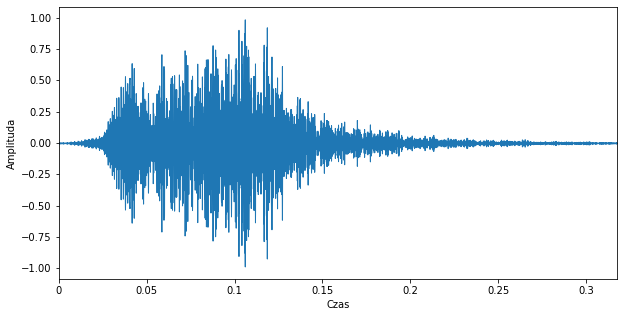

In [8]:
dat1, sampling_rate1 = librosa.load('/content/gdrive/MyDrive/Licencjat/fold5/100032-3-0-0.wav')
plt.figure(figsize=(10, 5))
librosa.display.waveplot(dat1, sr=sampling_rate1)
plt.ylabel('Amplituda')
plt.xlabel('Czas')
plt.savefig('waveform.png')

Podstawowy sposób prezentowania dźwięków

In [9]:
sampling_rates = []
data_all = []

for i in range(10):
  search_file = np.array(df.loc[df['classID'] == i].iloc[0])
  file_name = search_file[0] 
  folder = search_file[5]
  path_name = '/content/gdrive/MyDrive/Licencjat/fold' +  str(folder) +  '/' + str(file_name)
  data, sampling_rate = librosa.load(path_name)

  data_all.append(data)
  sampling_rates.append(sampling_rate) 

Krótkoczasowa transformata Fouriera dla sygnałów z poszczególnych klas, przy użyciu algorytmu szybkiej transformacji Fouriera. 

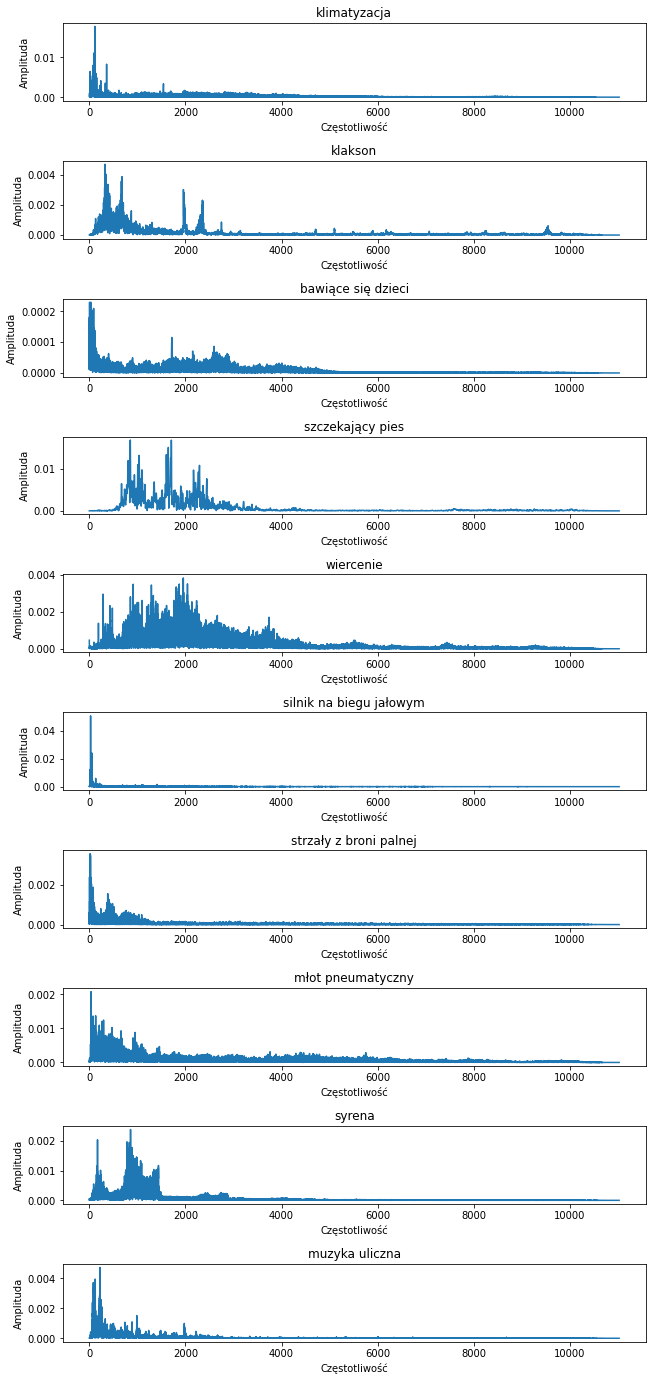

In [10]:
fig, axes = plt.subplots(nrows=10, ncols=1, sharex=True,
                        sharey=True, figsize=(10, 20))      
fig.tight_layout(pad=5)

for i in range(0, 10):
  plt.subplot(10,1,i+1)
  y, rate = get_fourier(data_all[i], sampling_rates[i])
  plt.plot(rate, y)
  plt.xlabel("Częstotliwość")
  plt.ylabel("Amplituda")
  plt.title(sound_names[i])

plt.savefig("wykres1.png")

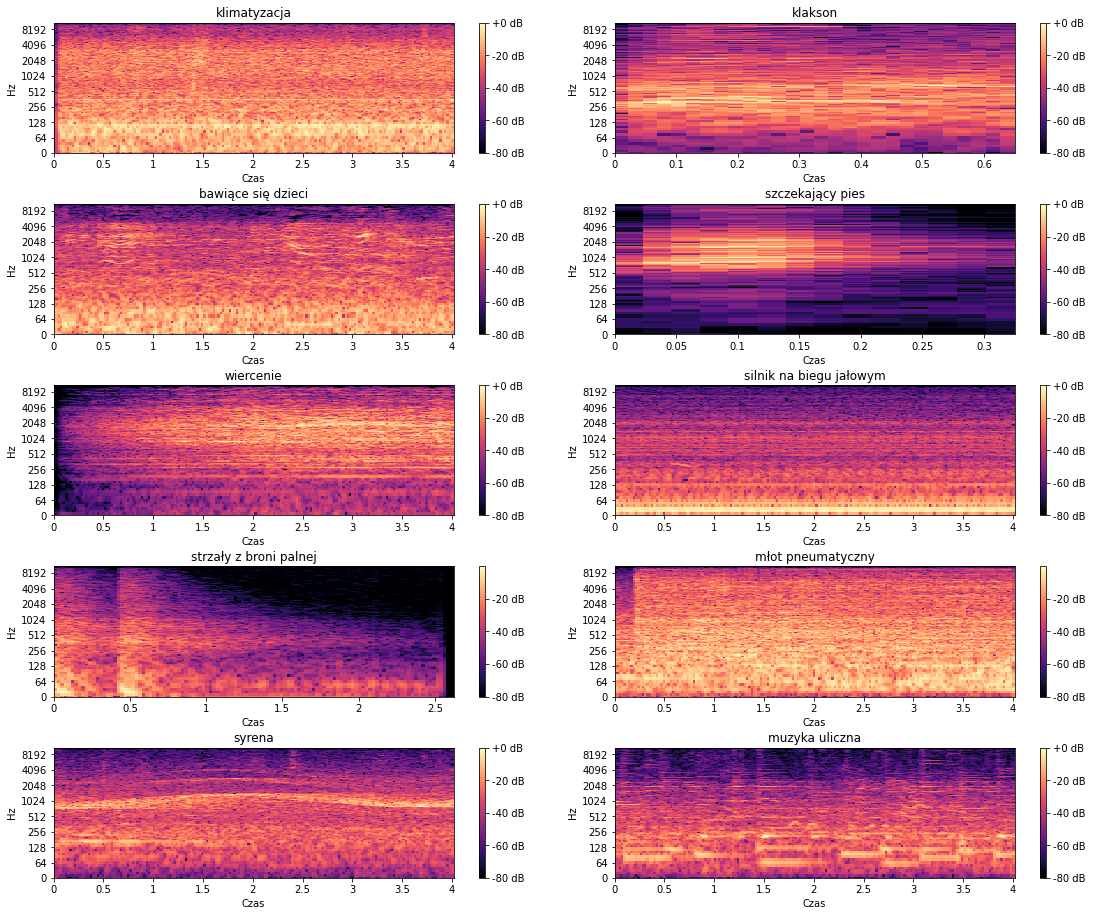

In [11]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16,13))
fig.tight_layout(pad=3.0)

for i in range(10):
  plt.subplot(5,2,i+1)
  D = librosa.amplitude_to_db(np.abs(librosa.stft(data_all[i])), ref=np.max)
  librosa.display.specshow(D, y_axis='log', x_axis='time')
  plt.xlabel("Czas")
  plt.colorbar(format='%+2.0f dB')

  plt.title(sound_names[i])

Prezentacja dźwięków z każdej kategorii jako przeskalowane spektrogramy w skali melowej. Można zaobserwować, że trudno o znalezienie dźwięku, który były bardzo podobny do drugiego w tej reprezentacji. Stanowi to dobry punkt wyjścia do tworzenia klasyfikatorów.